# Evaluate trained model

## Load model

In [1]:
%load_ext autoreload
%autoreload 2

import os
!ls -l {os.environ.get('RESULTS_DIR')}

total 1083392
drwxr-xr-x   2 p378593  staff         64 Jan 25 14:23 Mon Jan 25 14:23:10 CET 2021
drwxr-xr-x  25 p378593  staff        800 Jan 25 14:27 Mon Jan 25 14:23:27 CET 2021
drwxr-xr-x  11 p378593  staff        352 Jan 25 15:25 Mon Jan 25 15:24:13 CET 2021
drwxr-xr-x   2 p378593  staff         64 Jan 25 15:27 Mon Jan 25 15:27:03 CET 2021
drwxr-xr-x   2 p378593  staff         64 Jan 25 15:28 Mon Jan 25 15:28:21 CET 2021
drwxr-xr-x   2 p378593  staff         64 Jan 25 15:29 Mon Jan 25 15:29:47 CET 2021
drwxr-xr-x   7 p378593  staff        224 Jan 25 15:42 Mon Jan 25 15:37:18 CET 2021
drwxr-xr-x   2 p378593  staff         64 Jan 25 17:12 Mon Jan 25 17:11:31 CET 2021
drwxr-xr-x   4 p378593  staff        128 Jan 25 17:13 Mon Jan 25 17:12:37 CET 2021
drwxr-xr-x   6 p378593  staff        192 Jan 25 17:15 Mon Jan 25 17:14:44 CET 2021
drwxr-xr-x   2 p378593  staff         64 Jan 25 21:05 Mon Jan 25 21:05:15 CET 2021
drwxr-xr-x   2 p378593  staff         64 Jan 25 21:06 Mon Jan 25 21:06:00

In [2]:
run = "ddsp_gan_ae"
SAVE_DIR = f"{os.environ.get('RESULTS_DIR')}/{run}"

RnnFcDecoder:
{'ld_scaled': TensorShape([4, 1000, 512]), 'f0_scaled': TensorShape([4, 1000, 512]), 'z': TensorShape([4, 1000, 512])}
Original Audio


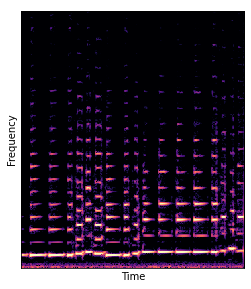

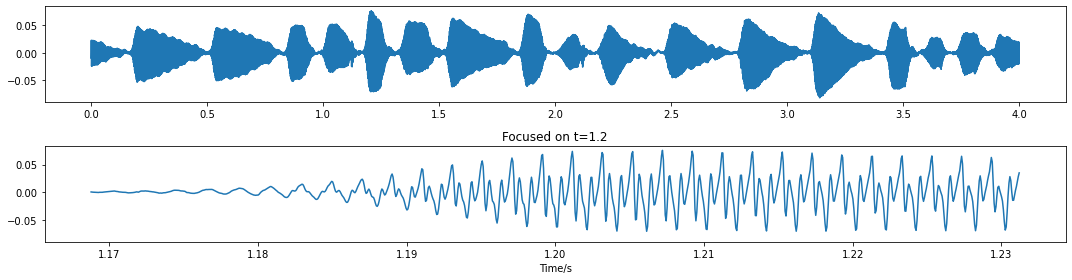

Resynthesis


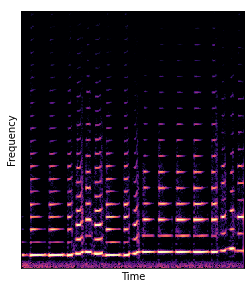

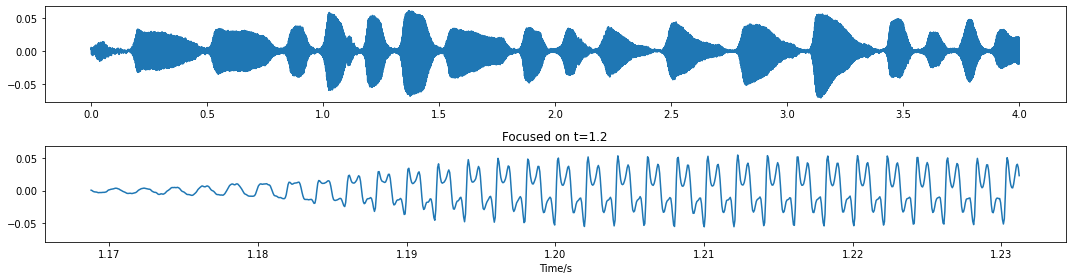

In [3]:
from ddsp.colab import jupyter_utils
import ddsp.training
import gin
from matplotlib import pyplot as plt
import numpy as np

# Parse the gin config.
gin_file = os.path.join(SAVE_DIR, 'operative_config-0.gin')
gin.parse_config_file(gin_file)

data_provider = ddsp.training.data.TFRecordProvider(os.environ.get("URMP_MONO"))
dataset = data_provider.get_batch(batch_size=4, shuffle=True)

try:
    batch = next(iter(dataset))
except OutOfRangeError:
    raise ValueError(
      'TFRecord contains no examples. Please try re-running the pipeline with '
      'different audio file(s).')


# Load model
model = ddsp.training.models.Autoencoder()
model.restore(SAVE_DIR)

# Resynthesize audio.
outputs = model(batch, training=False)
audio_gen = model.get_audio_from_outputs(outputs)
audio = batch['audio'][0]

print('Original Audio')
jupyter_utils.show_audio(batch['audio'][0])

print('Resynthesis')
jupyter_utils.show_audio(outputs['audio_synth'][0])
earlier = outputs['audio_synth'][0]

# Timbre interpolation

In [13]:
# Run this for some time then interrupt
for i, sample in enumerate(iter(data_provider.get_batch(1))):
    pass
i

KeyboardInterrupt: 

In [ ]:
sample_a = sample
sample_b = {k: batch[k][:1] for k in batch.keys()}
interpolate_by_keys = ['z']


def latent_interpolation(sample_a, sample_b, interpolate_by_key, model):
    latent_a = model(sample_a)
    latent_b = model(sample_b)


    def mix(a, b, p):
        return p*a + (1-p)*b

    mix_p = tf.reshape(tf.constant([1, 0.75, 0.5, 0.25, 0]), [-1, 1, 1])
    num_i = len(mix_p)

    latent = {}
    for k in sample_a.keys():
        if k in interpolate_by_keys:
            latent[k] = mix(latent_a[k], latent_b[k], mix_p)
        else:
            latent[k] = tf.repeat(latent_a[k], num_i, axis=0)

    interpolated = model.decode(latent)

    print("Original")
    jupyter_utils.show_audio(sample_a['audio'][0])
    for i in range(num_i):
        print("Interpolation at", mix_p[i])
        jupyter_utils.show_audio(interpolated[i])
    print("Target timbre")
    jupyter_utils.show_audio(sample_b['audio'][0])
    return latent


latent_interpolation = latent_interpolation(sample_a, sample_b, interpolate_by_keys, model)

In [69]:
jupyter_utils.dict_shape(latent_a)

inputs
  audio
    (1, 64000)
  f0_confidence
    (1, 1000)
  f0_hz
    (1, 1000, 1)
  loudness_db
    (1, 1000, 1)
  f0_scaled
    (1, 1000, 1)
  ld_scaled
    (1, 1000, 1)
  z
    (1, 1000, 16)
  amps
    (1, 1000, 1)
  harmonic_distribution
    (1, 1000, 100)
  noise_magnitudes
    (1, 1000, 65)
audio
  (1, 64000)
f0_confidence
  (1, 1000)
f0_hz
  (1, 1000, 1)
loudness_db
  (1, 1000, 1)
f0_scaled
  (1, 1000, 1)
ld_scaled
  (1, 1000, 1)
z
  (1, 1000, 16)
amps
  (1, 1000, 1)
harmonic_distribution
  (1, 1000, 100)
noise_magnitudes
  (1, 1000, 65)
harmonic
  signal
    (1, 64000)
  controls
    amplitudes
      (1, 1000, 1)
    harmonic_distribution
      (1, 1000, 100)
    f0_hz
      (1, 1000, 1)
filtered_noise
  signal
    (1, 64000)
  controls
    magnitudes
      (1, 1000, 65)
add
  signal
    (1, 64000)
  controls
    signal_one
      (1, 64000)
    signal_two
      (1, 64000)
out
  signal
    (1, 64000)
  controls
    signal_one
      (1, 64000)
    signal_two
      (1, 64000)
au

Now also shift the target freqeuncy

RnnFcDecoder:
{'ld_scaled': TensorShape([1, 1000, 512]), 'f0_scaled': TensorShape([1, 1000, 512]), 'z': TensorShape([1, 1000, 512])}
Discriminator input: [TensorShape([1, 64000, 1]), TensorShape([1, 64000, 1]), TensorShape([1, 64000, 1])]
RnnFcDecoder:
{'ld_scaled': TensorShape([1, 1000, 512]), 'f0_scaled': TensorShape([1, 1000, 512]), 'z': TensorShape([1, 1000, 512])}
Discriminator input: [TensorShape([1, 64000, 1]), TensorShape([1, 64000, 1]), TensorShape([1, 64000, 1])]
RnnFcDecoder:
{'ld_scaled': TensorShape([5, 1000, 512]), 'f0_scaled': TensorShape([5, 1000, 512]), 'z': TensorShape([5, 1000, 512])}
Original


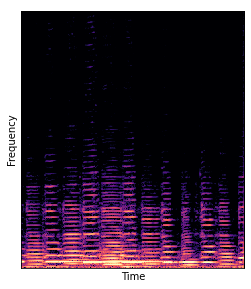

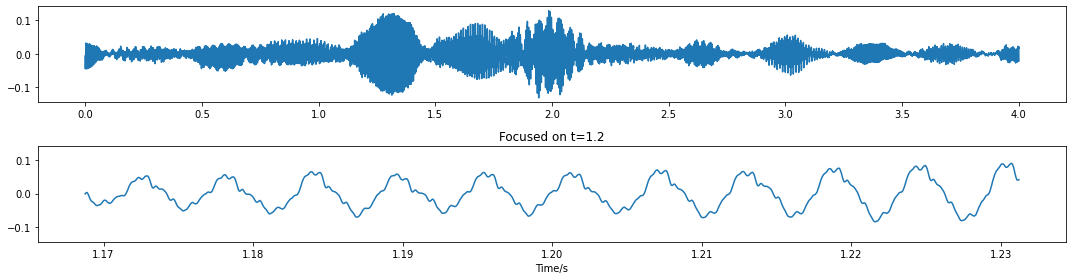

Interpolation at tf.Tensor([[1.]], shape=(1, 1), dtype=float32)


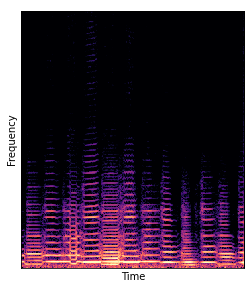

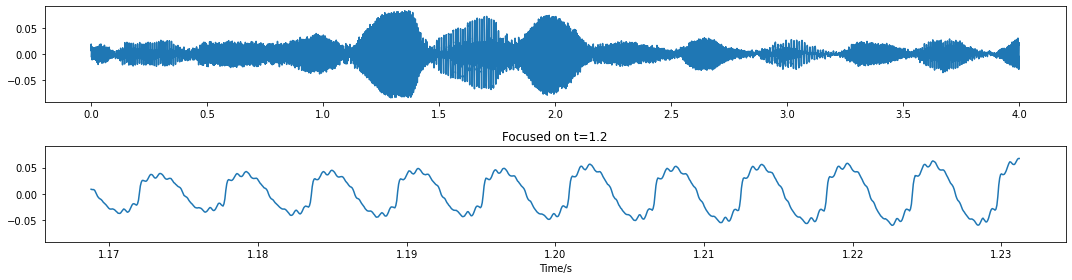

Interpolation at tf.Tensor([[0.75]], shape=(1, 1), dtype=float32)


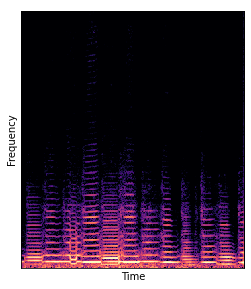

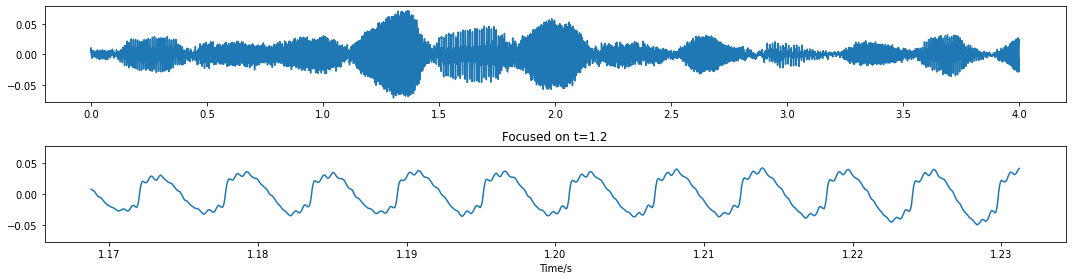

Interpolation at tf.Tensor([[0.5]], shape=(1, 1), dtype=float32)


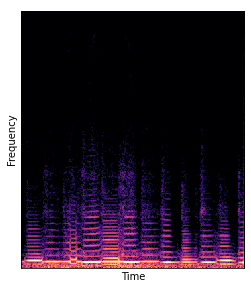

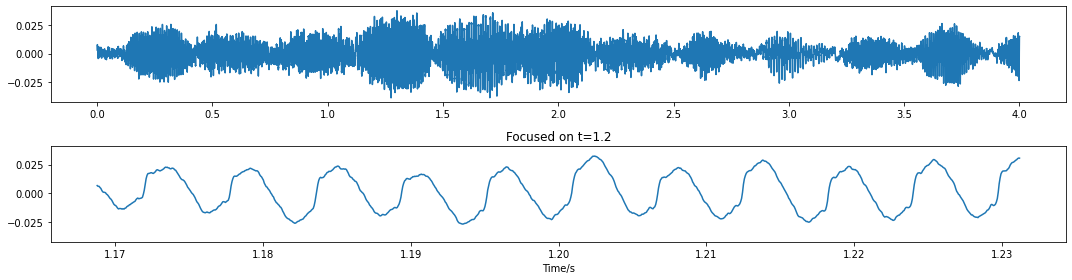

Interpolation at tf.Tensor([[0.25]], shape=(1, 1), dtype=float32)


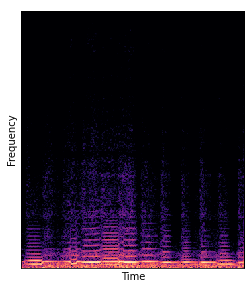

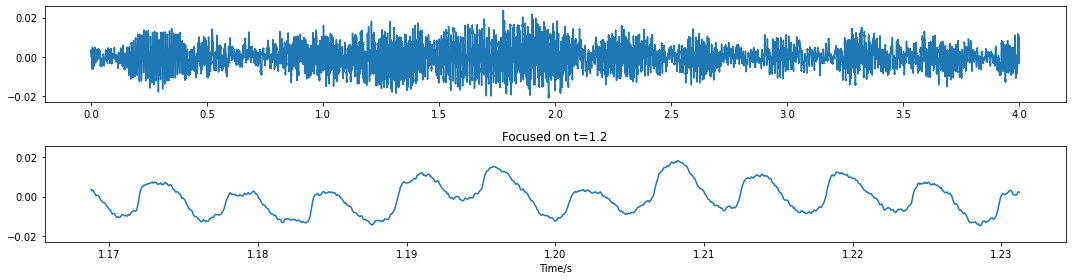

Interpolation at tf.Tensor([[0.]], shape=(1, 1), dtype=float32)


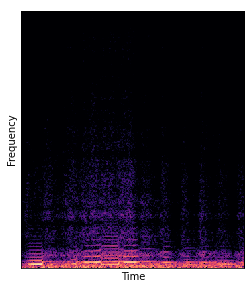

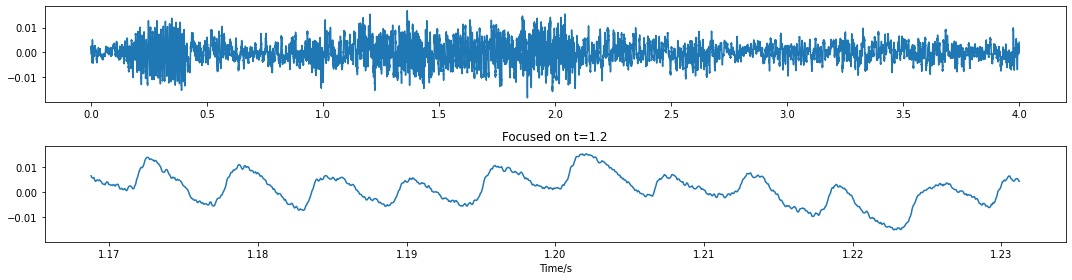

Target timbre


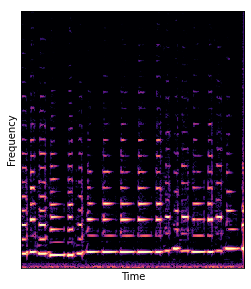

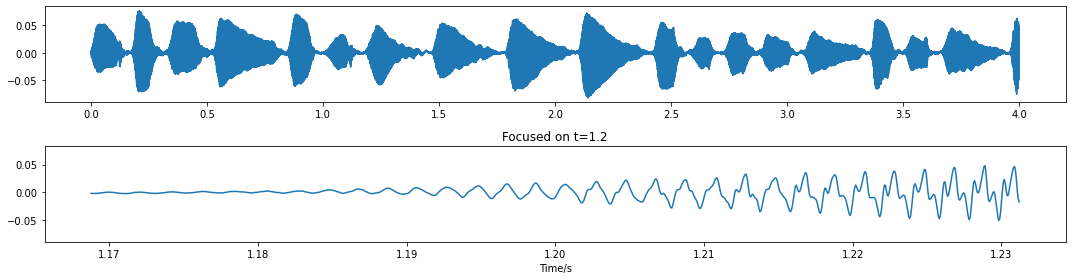

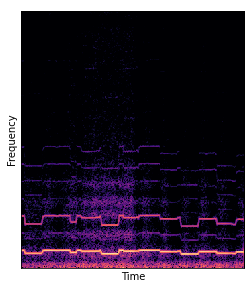

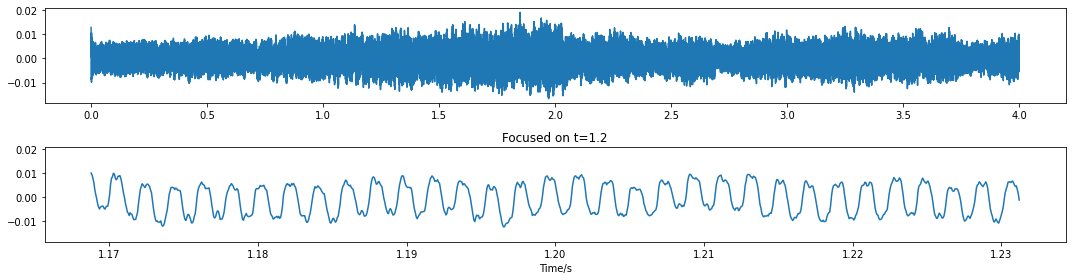

In [89]:
latent_a = model(sample_a)
latent_b = model(sample_b)


def mix(a, b, p):
    return p*a + (1-p)*b

mix_p = tf.reshape(tf.constant([1, 0.75, 0.5, 0.25, 0]), [-1, 1, 1])
num_i = len(mix_p)

latent = {}
for k in sample_a.keys():
    if k == "f0_scaled":
        latent[k] = latent_a[k] + (tf.reduce_mean(latent_b[k], keepdims=True)-tf.reduce_mean(latent_a[k], keepdims=True))*(1-mix_p)
    elif k in interpolate_by_keys:
        latent[k] = mix(latent_a[k], tf.reduce_mean(latent_b[k], axis=1, keepdims=True), mix_p)
    else:
        latent[k] = tf.repeat(latent_a[k], num_i, axis=0)

interpolated = model.decode(latent)

print("Original")
jupyter_utils.show_audio(sample_a['audio'][0])
for i in range(num_i):
    print("Interpolation at", mix_p[i])
    jupyter_utils.show_audio(interpolated[i])


print("Target timbre")
jupyter_utils.show_audio(sample_b['audio'][0])


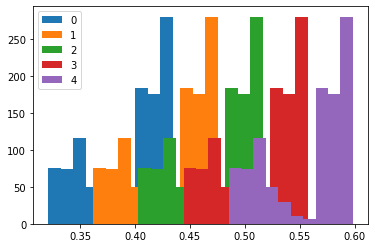

In [91]:
plt.clf()
for i in range(5):
    plt.hist(latent['f0_scaled'][i].numpy().flatten(), label=i)
plt.legend()
plt.show()

In [61]:
from matplotlib import pyplot as plt

plt.hist(latent_a['f0_scaled'])

<tf.Tensor: shape=(), dtype=float32, numpy=382.13846>

In [58]:
x = np.random.randn(500)

fig = go.Figure(data=[go.Histogram(x=x)])
fig.show()

In [86]:
k = "f0_scaled"
(tf.reduce_mean(latent_a[k], keepdims=True) + tf.reduce_mean(latent_b[k], keepdims=True))*(1-mix_p)

<tf.Tensor: shape=(5, 1, 1), dtype=float32, numpy=
array([[[0.        ]],

       [[0.23833957]],

       [[0.47667915]],

       [[0.71501875]],

       [[0.9533583 ]]], dtype=float32)>

In [84]:
tf.reduce_mean(latent_a[k], keepdims=True)

<tf.Tensor: shape=(1, 1, 1), dtype=float32, numpy=array([[[0.39467272]]], dtype=float32)>